In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import scipy as sp
import h5py
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm, solve_sylvester, solve_lyapunov
import matplotlib.pyplot as plt
import sys
import pseudo
import os
import glob
import miscUtil
import ops
%matplotlib inline
#%matplotlib notebook

os.environ['DATA'] = os.environ['DATA186']
physDataDir = os.environ['DATA'] + 'phys/'
specDataDir = os.environ['DATA'] + 'spec/'
covDataDir = os.environ['DATA'] + 'cov/'
libDir = os.environ['LINLIB']
figureFolder = 'newFigures/'

# Max amplification for laminar base
Jovanovic & Bamieh (2005) JFM

In [3]:
N=100
aArr = 10**np.linspace(-4., 0.5, 30)
bArr = 10**np.linspace(-2., 1.2, 60)
H2normArr = np.zeros((aArr.size, bArr.size))
H2normArrTest = np.zeros((aArr.size, bArr.size))

for ind0 in range(aArr.size):
    a = aArr[ind0]
    for ind1 in range(bArr.size):
        b = bArr[ind1]
        k2 = a**2 + b**2
        I = np.identity(N); Z = np.zeros((N,N), dtype=np.complex)
        covMat = np.identity(3*N)
        statInst = ops.statComp(Re=2000., a=a, b=b, N=N, covMat = covMat)
        statInst.U = 1. - statInst.y**2
        statInst.dU = -2.*statInst.y
        statInst.d2U = -2.*np.ones(N)
        Umat = np.diag(statInst.U)
        dUmat = np.diag(statInst.dU)
        d2Umat = np.diag(statInst.d2U)
        Re = statInst.Re
        
        A, C, B = statInst.makeSystem()
        Badj = C.copy()
        Cadj = B.copy()
        
        # Building Aadj:
        Aadj = np.zeros((2*N, 2*N), dtype=np.complex)
        Delta = statInst.D2 - k2 * I
        DeltaInv = np.linalg.solve(Delta, I)
        Aadj11 = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + \
                1./Re*DeltaInv @ (Delta @ Delta)
        Aadj22 = 1.j*a*Umat + 1./Re*Delta
        Aadj21 = -1.j*b*DeltaInv @ dUmat
        
        Aadj = np.vstack(( 
                np.hstack(( Aadj11, Aadj21 )),
                np.hstack((  Z    , Aadj22 ))   ))
        
        # Solve Sylvester equation, AX + XB = Q, arguments to the function are A,B,Q
        # In present formulation, the equation is AX + X A* = - B B*
        #X = solve_sylvester(A, Aadj, - B @ Badj)
        X = solve_sylvester(A, A.conj().T, -B @ Badj )
                
        
        H2normArr[ind0,ind1] = np.sqrt(np.trace( X @ Cadj @ C))
        

Using parameters Re=2000, alfa=25.4, kapa=0.426, N=100
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.01 2000.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")
/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:45: ComplexWarning: Casting complex values to real discards the imaginary part


Using parameters Re=2000, alfa=25.4, kapa=0.426, N=100
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.0113301924881 2000.0
Using parameters Re=2000, alfa=25.4, kapa=0.426, N=100
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.0001 0.0128373261818 2000.0
Using parameters Re=2000, alfa=25.4, kapa=0.426, N=100
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo modul

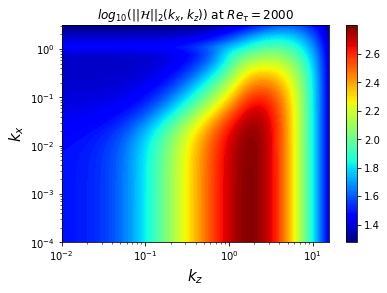

In [4]:
plt.contourf(bArr, aArr, np.log10(H2normArr),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.colorbar(ticks=np.arange(1.4,2.7,0.2))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}||_2 (k_x,k_z))$ at $Re_\\tau = 2000$")
plt.savefig('figures/'+'gainLaminar.pdf',format='pdf')
plt.show()

# Max amplification for turbulent base
Moarref et. al. 2013 (JFM); Model based scaling

Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150


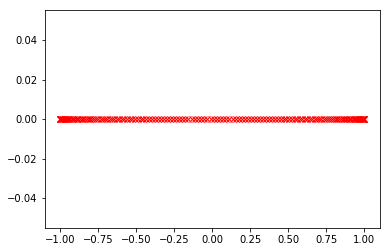

/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:230: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 17.978885957543874 125.85220170280711 2003.0


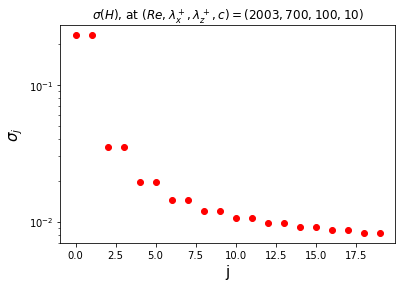

In [4]:
Re = 2003.; alfa = 25.4; kapa = 0.426; N = 150

# Fig 4.a in paper is for lx+ = 700, lz+ = 100, c = 10
# a = 2*pi/lx = 2*pi/(lx+ /ReTau) = ReTau * 2*pi/lx+
a = 2.*np.pi*Re/700.
b = 2.*np.pi*Re/100.
c = 10.; omega = a*c


statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
plt.plot(statInst.y, statInst.U - ops.turbMeanChannel(N=N,Re=Re,alfa=alfa,kapa=kapa)['U'],'rx'); plt.show()

A = statInst.OSS(a=a,b=b)
C = statInst.velVor2primitivesMat(a=a,b=b)
Cadj = statInst.primitives2velVorMat(a=a,b=b)
R = ( 1.j*omega*np.identity(2*N) + A )
R = - np.linalg.solve(R,np.identity(R.shape[0]))
H = C @ R @ Cadj
H = statInst._weightMat(H)

U,S,V = np.linalg.svd(H)
plt.plot(np.arange(20),S[:20],'ro')
plt.yscale("log")
plt.xlabel("j",fontsize=15); plt.ylabel("$\\sigma_j$",fontsize=15)
plt.title("$\\sigma(H)$, at $(Re,\\lambda^+_x,\\lambda^+_z,c)=(2003,700,100,10)$")
plt.savefig(figureFolder+'svalsRe2003lx700lz100.pdf',format='pdf')
plt.show()

In [6]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = statInst.U[5]; omega = a*c
        
        A = statInst.OSS(a=a,b=b)
        C = statInst.velVor2primitivesMat(a=a,b=b)
        Cadj = statInst.primitives2velVorMat(a=a,b=b)
        R = ( 1.j*omega*np.identity(2*N) + A )
        R = - np.linalg.solve(R,np.identity(R.shape[0]))
        H = C @ R @ Cadj
        H = statInst._weightMat(H)

        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 666.804847975 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy

In [7]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_yp100 = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = 16.2; omega = a*c
        # This c is roughly U(yp=100)
        
        A = statInst.OSS(a=a,b=b)
        C = statInst.velVor2primitivesMat(a=a,b=b)
        Cadj = statInst.primitives2velVorMat(a=a,b=b)
        R = ( 1.j*omega*np.identity(2*N) + A )
        R = - np.linalg.solve(R,np.identity(R.shape[0]))
        H = C @ R @ Cadj
        H = statInst._weightMat(H)

        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_yp100[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 666.804847975 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy

In [8]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_y02 = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = 19.7; omega = a*c
        # This c is roughly U(y=0.2)
        
        A = statInst.OSS(a=a,b=b)
        C = statInst.velVor2primitivesMat(a=a,b=b)
        Cadj = statInst.primitives2velVorMat(a=a,b=b)
        R = ( 1.j*omega*np.identity(2*N) + A )
        R = - np.linalg.solve(R,np.identity(R.shape[0]))
        H = C @ R @ Cadj
        H = statInst._weightMat(H)

        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_y02[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 666.804847975 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy

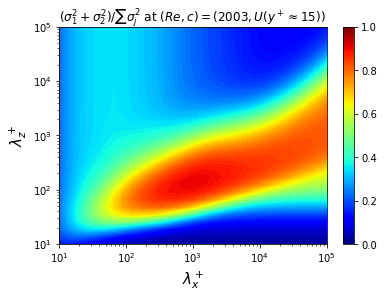

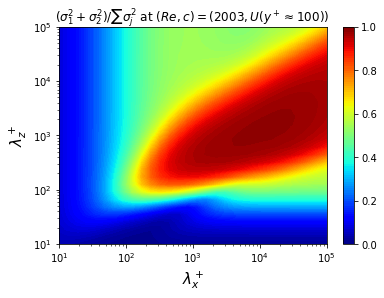

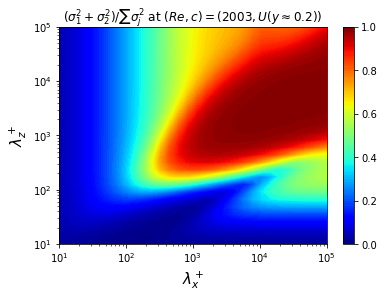

In [9]:
levels = np.linspace(0.,1.0,101)
cticks = np.linspace(0.,1.,6)

plt.contourf(lxpArr, lzpArr, svals2norm.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y^+\\approx 15))$")
plt.savefig(figureFolder+'svals12norm_yp15.pdf',format='pdf')
plt.show()

plt.contourf(lxpArr, lzpArr, svals2norm_yp100.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y^+\\approx 100))$")
plt.savefig(figureFolder+'svals12norm_yp100.pdf',format='pdf')
plt.show()

plt.contourf(lxpArr, lzpArr, svals2norm_y02.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y\\approx 0.2))$")
plt.savefig(figureFolder+'svals12norm_y02.pdf',format='pdf')
plt.show()

# Max amplification for turbulent base
Comparing with Moarref et. al. 2013 (JFM); Model based scaling
using the formulation of Jovanovic & Bamieh 2005

Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 17.978885957543874 125.85220170280711 2003.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


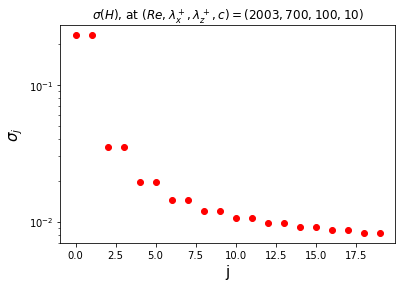

In [10]:
Re = 2003.; alfa = 25.4; kapa = 0.426; N = 150

# Fig 4.a in paper is for lx+ = 700, lz+ = 100, c = 10
# a = 2*pi/lx = 2*pi/(lx+ /ReTau) = ReTau * 2*pi/lx+
a = 2.*np.pi*Re/700.
b = 2.*np.pi*Re/100.
c = 10.; omega = a*c


statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))

A, C, B = statInst.makeSystem()
I = np.identity(A.shape[0])
R = (1.j*omega*I + A)
R = -np.linalg.solve(R, I)
H = C @ R @ B

U,S,V = np.linalg.svd(H)
plt.plot(np.arange(20),S[:20],'ro')

plt.yscale("log")
plt.xlabel("j",fontsize=15); plt.ylabel("$\\sigma_j$",fontsize=15)
plt.title("$\\sigma(H)$, at $(Re,\\lambda^+_x,\\lambda^+_z,c)=(2003,700,100,10)$")
plt.savefig(figureFolder+'svalsRe2003lx700lz100_JB.pdf',format='pdf')
plt.show()

In [11]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_state = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = statInst.U[5]; omega = a*c
        
        A, C, B = statInst.makeSystem()
        I = np.identity(A.shape[0])
        R = (1.j*omega*I + A)
        R = -np.linalg.solve(R, I)
        H = C @ R @ B
        
        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_state[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 666.804847975 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: ps

In [12]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_yp100_state = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = 16.2; omega = a*c
        
        A, C, B = statInst.makeSystem()
        I = np.identity(A.shape[0])
        R = (1.j*omega*I + A)
        R = -np.linalg.solve(R, I)
        H = C @ R @ B
        
        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_yp100_state[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 666.804847975 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: ps

In [13]:
N=150; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,30)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_y02_state = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = 19.7; omega = a*c
        
        A, C, B = statInst.makeSystem()
        I = np.identity(A.shape[0])
        R = (1.j*omega*I + A)
        R = -np.linalg.solve(R, I)
        H = C @ R @ B
        
        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_y02_state[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 666.804847975 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: ps

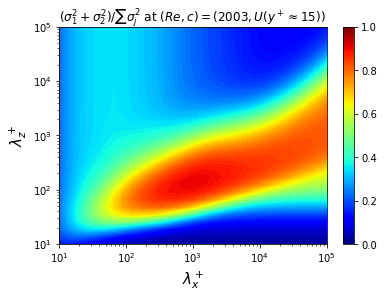

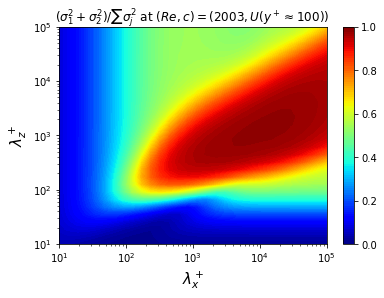

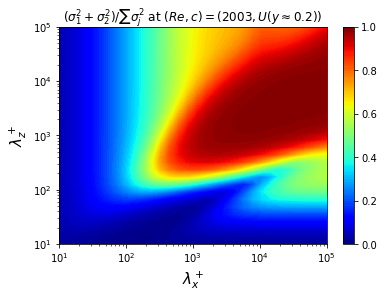

In [14]:
levels = np.linspace(0.,1.0,101)
cticks = np.linspace(0.,1.,6)

plt.contourf(lxpArr, lzpArr, svals2norm_state.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y^+\\approx 15))$")
plt.savefig(figureFolder+'svals12norm_yp15_JB.pdf',format='pdf')
plt.show()

plt.contourf(lxpArr, lzpArr, svals2norm_yp100_state.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y^+\\approx 100))$")
plt.savefig(figureFolder+'svals12norm_yp100_JB.pdf',format='pdf')
plt.show()

plt.contourf(lxpArr, lzpArr, svals2norm_y02_state.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y\\approx 0.2))$")
plt.savefig(figureFolder+'svals12norm_y02_JB.pdf',format='pdf')
plt.show()

# Optimal forcing response with eddy viscosity
Hwang & Cossu 2010 (JFM); Linear non-normal energy amplification ...

In [ ]:
# First, amplification due to stochastic forcing
N=150; Re = 10000.
bArr = 10** np.linspace(-1., 5., 13)
#aArr= np.array([0., 0.1, 0.2, 0.5, 1., 2., 5., 10.])
aArr = np.array([0.,10.])
Varr = np.zeros((aArr.size, bArr.size)) # max ampl. 

statInst = ops.statComp(a=aArr[0], b=bArr[0], N=N, Re=Re, covMat = np.identity(3*N))

for ind0 in range(aArr.size):
    a = aArr[ind0]
    for ind1 in range(bArr.size):
        b = bArr[ind1]
        N = np.int(200+ 75*np.log10(b))
        k2 = a**2 + b**2
        I2 = np.identity(2*N, dtype=np.complex)
        
        if statInst.N != N:
            statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        else:
            statInst.a = a; statInst.b = b
        #statInst.nu = ops.turbMeanChannel(N=statInst.N,Re=Re)['nu']
        statInst.nu = np.ones(statInst.N)
        A, C, B = statInst.makeSystemNew()
        #B = C.conj().T
        #Aadj, Cadj, Badj = statInst.makeAdjSystem(nu=statInst.nu)
        Aadj = A.conj().T; Badj = B.conj().T; Cadj = C.conj().T
        X = solve_lyapunov(A, -B @ Badj )
        
        Varr[ind0,ind1] = np.trace( C @ X @ Cadj )
        
        



In [33]:
# Amplification due to harmonic forcing
N=150; Re = 10000.
bArr = 10** np.linspace(-1., 5., 31)
aArr= np.array([0.,  0.2,  1., 5., 10.])
#aArr= np.array([0.,1.,10.])
#bArr = np.array([1000.]); aArr = np.array([0.])
Garr = np.zeros((aArr.size, bArr.size)) # max ampl. 
cArr = np.linspace(5., 25., 40)

statInst = ops.statComp(a=aArr[0], b=bArr[0], N=N, Re=Re, covMat = np.identity(3*N))
for ind0 in range(aArr.size):
    a = aArr[ind0]
    for ind1 in range(bArr.size):
        b = bArr[ind1]
        k2 = a**2 + b**2
        N = np.int(200+ 75*np.log10(b))
        
        if statInst.N != N:
            statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
            weightDict = pseudo.weightMats(N=statInst.N)
            W3s = weightDict['W3Sqrt']
            W3si= weightDict['W3SqrtInv']
        else:
            statInst.a = a; statInst.b = b
        statInst.nu = ops.turbMeanChannel(N=statInst.N,Re=Re)['nu']
        #statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        #A, C, B = statInst.makeSystemNew()
        #A = statInst.dynamicsMat()
        #C = statInst.outputMat()
        #B = statInst.primitives2velVorMat()
        A, C, B = statInst.makeSystem()
        I2 = np.identity(A.shape[0])
        
        GtmpArr = np.zeros(cArr.size)
        for ind2 in range(cArr.size):
            c = cArr[ind2]; omega = a*c

            R = (1.j*omega*I2 + A)
            R = -np.linalg.solve(R, I2)
            H = C @ R @ B
            #H = W3s @ H @ W3si

            try:
                U,S,V = np.linalg.svd(H)
            except:
                print("SVD failed for a,b,c:",a,b,c)
            GtmpArr[ind2] = S[0]**2
        
        Garr[ind0, ind1] = np.max(GtmpArr)
        
        



Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 8.1.1.
New in this version: Eddy viscosity fixed
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=125
Initialized instance of 'linearize', version 8.1.1.
New in this version: Eddy viscosity fixed
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=125


/home/svadarevu/gitwork/linear/library/ops.py:190: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:230: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 0.0 0.1 10000.0
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=140
Initialized instance of 'linearize', version 8.1.1.
New in this version: Eddy viscosity fixed
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=140
a, b, Re: 0.0 0.158489319246 10000.0
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=155
Initialized instance of 'linearize', version 8.1.1.
New in this version: Eddy viscosity fixed
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=155
a, b, Re: 0.0 0.251188643151 10000.0
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=170
Initialized instance of 'linearize', version 8.1.1.
New in this version: Eddy viscosity fixed
structMat has not been supplied or is not a nump

In [14]:
np.linalg.norm(B @ Badj)

4730317347.6472073

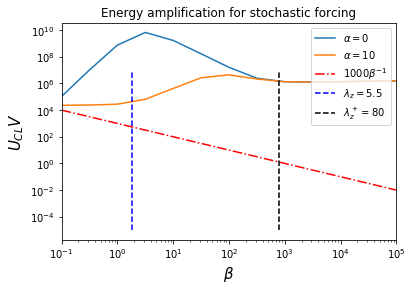

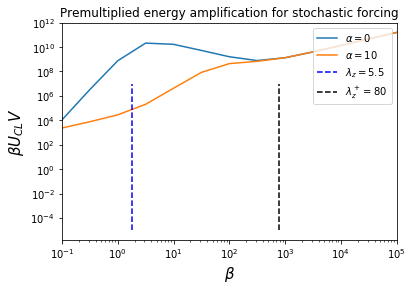

In [18]:
Ue = np.max(statInst.U)
lz0 = 3.5; b0 = 2.*np.pi/lz0
lz0p = 80; b0p = 2.*np.pi/(lz0p/statInst.Re)

#Ue = 12.5
#bArr = 10.** np.linspace(-1.,4.,51)
for k in range(Varr.shape[0]):
    plt.plot(bArr, Ue*Varr[k])
plt.plot(bArr, 1000./bArr, 'r-.')
plt.plot(b0*np.ones(25), 10**np.linspace(-5,7,25), 'b--')
plt.plot(b0p*np.ones(25), 10**np.linspace(-5,7,25), 'k--')
plt.xscale("log") ; plt.yscale("log")
plt.xlabel("$\\beta$", fontsize=15); plt.ylabel("$U_{CL} V$",fontsize=15)
plt.title("Energy amplification for stochastic forcing")
legList = ['$\\alpha=$%.2g'%aa for aa in list(aArr)]
legList.append('$1000\\beta^{-1}$')
legList.append('$\\lambda_z=5.5$'); legList.append('$\\lambda_z^+=80$')
plt.legend(legList,loc=1)
#plt.ylim([0.01, 10000])
plt.xlim([0.1, 1.0e05])
#plt.savefig(figureFolder+"ampStoEddy.pdf", format="pdf")
plt.show()

for k in range(Varr.shape[0]):
    plt.plot(bArr, Ue*bArr*Varr[k])
#plt.plot(bArr, 1000./bArr, 'r--')
plt.plot(b0*np.ones(25), 10**np.linspace(-5,7,25), 'b--')
plt.plot(b0p*np.ones(25), 10**np.linspace(-5,7,25), 'k--')
plt.xscale("log") ; plt.yscale("log")
plt.xlabel("$\\beta$", fontsize=15); plt.ylabel("$\\beta U_{CL} V$",fontsize=15)
plt.title("Premultiplied energy amplification for stochastic forcing")
legList = ['$\\alpha=$%.2g'%aa for aa in list(aArr)]
legList.append('$\\lambda_z=5.5$'); legList.append('$\\lambda_z^+=80$')
plt.legend(legList,loc=1)
#plt.ylim([100, 10000])
plt.xlim([0.1, 1.0e05])
#plt.savefig(figureFolder+"preAmpStoEddy.pdf", format="pdf")
plt.show()

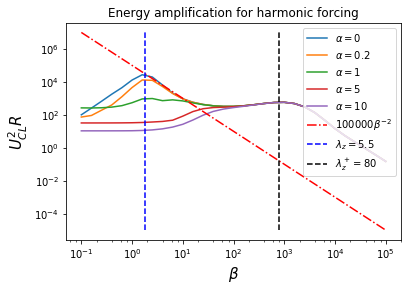

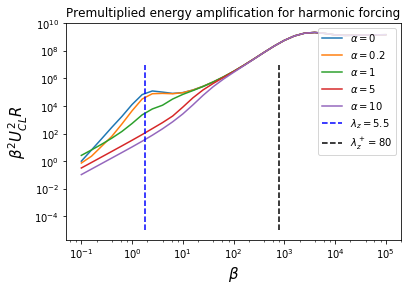

In [34]:
lz0 = 3.5; b0 = 2.*np.pi/lz0
lz0p = 80; b0p = 2.*np.pi/(lz0p/statInst.Re)
Ue = np.max(statInst.U)
#bArr = 10.** np.linspace(-1.,5.,31)
#bArr = 10.**np.linspace(-1.,5.,6)
for k in range(Garr.shape[0]):
    plt.plot(bArr, Ue**2 * Garr[k])
plt.plot(bArr, 100000./bArr**2, 'r-.')
plt.plot(b0*np.ones(25), 10**np.linspace(-5,7,25), 'b--')
plt.plot(b0p*np.ones(25), 10**np.linspace(-5,7,25), 'k--')
plt.xscale("log") ; plt.yscale("log")
plt.xlabel("$\\beta$", fontsize=15); plt.ylabel("$U^2_{CL} R$",fontsize=15)
plt.title("Energy amplification for harmonic forcing")
legList = ['$\\alpha=$%.2g'%aa for aa in list(aArr)]
legList.append('$100000\\beta^{-2}$')
legList.append('$\\lambda_z=5.5$'); legList.append('$\\lambda_z^+=80$')
plt.legend(legList,loc=1)
#plt.ylim([1.0e-05, 1.0e07])
#plt.savefig(figureFolder+"ampHarEddy.pdf", format="pdf")
plt.show()

for k in range(Garr.shape[0]):
    plt.plot(bArr, Ue**2 * bArr **2 * Garr[k])
plt.plot(b0*np.ones(25), 10**np.linspace(-5,7,25), 'b--')
plt.plot(b0p*np.ones(25), 10**np.linspace(-5,7,25), 'k--')
plt.xscale("log") ; plt.yscale("log")
plt.xlabel("$\\beta$", fontsize=15); plt.ylabel("$\\beta^2 U^2_{CL} R$",fontsize=15)
plt.title("Premultiplied energy amplification for harmonic forcing")
legList = ['$\\alpha=$%.2g'%aa for aa in list(aArr)]
#legList.append('$1000\\beta^{-2}$')
legList.append('$\\lambda_z=5.5$'); legList.append('$\\lambda_z^+=80$')
plt.legend(legList,loc=1)
#plt.ylim([1.0e03, 1.0e07])
#plt.savefig(figureFolder+"preAmpHarEddy.pdf", format="pdf")
plt.show()


# Verify velocity vorticity to primitives and vice-versa

Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


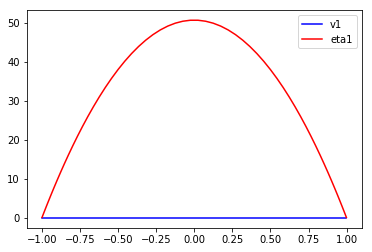

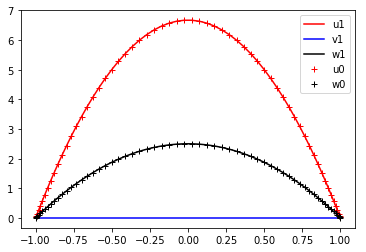

Divergence of uvw is  1.18318893739e-15
Difference in v from veta and uvw are 0.0


In [15]:
# We need two state-vectors first
# They have to be divergence free, and satisfy the BCs
# It's easier to ensure divergence-free condition if I start with velocity vorticity
statInst = ops.statComp(a=2.5, b=20./3., N=62, Re=186.)
a = statInst.a; b = statInst.b; N = statInst.N
y = statInst.y
# Doesn't matter what the exact functions are, as long as BCs are good
eta1 = 1.j*(a**2 + b**2) * (1. - y**2)
v1 = np.zeros(statInst.N)
# For the above field, u and w should be
u0 = b*(1.-y**2); w0 = -a*(1.-y**2)

veta1 = np.concatenate((v1, eta1))
uvw1 = statInst.velVor2primitivesMat(a=a,b=b) @ veta1

# Ensure that the divergence is actually zero
div1 = 1.j*a*uvw1[:N] + statInst.D1 @ uvw1[N:2*N] + 1.j*b*uvw1[2*N:3*N]

plt.plot(statInst.y, np.abs(veta1[0*N:1*N]), 'b')
plt.plot(statInst.y, np.abs(veta1[1*N:2*N]), 'r')
plt.legend(['v1','eta1', 'v2', 'eta2'])
plt.show()


plt.plot(statInst.y, np.abs(uvw1[0*N:1*N]), 'r')
plt.plot(statInst.y, np.abs(uvw1[1*N:2*N]), 'b')
plt.plot(statInst.y, np.abs(uvw1[2*N:3*N]), 'k')
plt.plot(statInst.y, np.abs(u0), 'r+')
plt.plot(statInst.y, np.abs(w0), 'k+')
plt.legend(['u1','v1','w1', 'u0', 'w0'])
plt.show()

print("Divergence of uvw is ", pseudo.chebnorm(div1,N))
print("Difference in v from veta and uvw are", 
      pseudo.chebnorm(veta1[:N]-uvw1[N:2*N], N))




For the simple velocity mode, the conversion from primitives to v-eta and vice-versa is accurate. The divergence is also zero. 

This means the matrices $B_\phi$ and $C_\phi$ in linearize or statComp (classes) are accurate.



# Norms for $[u,v,w] = [ \beta(1-y^2), 0, -\alpha(1-y^2) ]  $

The energy norm for this field should be $8(\alpha^2 + \beta^2)/15$

In [16]:
statInst = ops.statComp(a=2.5, b=20./3., N=62, Re=186.)
a = statInst.a; b = statInst.b; N = statInst.N
y = statInst.y
# Doesn't matter what the exact functions are, as long as BCs are good
eta = 1.j*(a**2 + b**2) * (1. - y**2)
v = np.zeros(statInst.N)
veta = np.concatenate((v,eta))
uvw = statInst.velVor2primitivesMat(a=a,b=b) @ veta
uvwWeighted = statInst._weightVec(uvw)

# Numpy's linalg norm definition takes a square-root that isn't needed
uvwNorm1 = np.linalg.norm(uvwWeighted)**2
uvwNorm2 = pseudo.chebnorm(uvw,N)**2

A,C,B = statInst.makeSystem()
state = B @ uvwWeighted

stateNorm1 = np.linalg.norm(state)**2
stateNorm2 = np.abs(np.sum(state * state.conj()))
stateNorm3 = np.dot(state, state.conj())

energyNorm = 8.*(a**2 + b**2)/15.

uvwWeighted_ = C @ state
tol = 1.0e-12
_approx = lambda scal1, scal2: np.abs(scal1-scal2) < tol

print();print();print()
print("Energy norm for the field should be ", energyNorm)
print("Is norm from unweighted uvw correct?\n\t", _approx(uvwNorm2, energyNorm))
print("Is norm from weighted uvw correct?\n\t", _approx(uvwNorm1, energyNorm))
print("Is norm from state (np.linalg.norm) correct?\n\t", _approx(stateNorm1, energyNorm))
print("Is norm from state (state*state.conj()) correct?\n\t", _approx(stateNorm2, energyNorm))
print("Is dot of state the same as norm?\n\t", _approx(stateNorm1, stateNorm3))

print("Diff between original weighted uvw and after going throw C then B:", 
     np.linalg.norm(uvwWeighted - uvwWeighted_))




Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666667 186.0



Energy norm for the field should be  27.03703703703704
Is norm from unweighted uvw correct?
	 True
Is norm from weighted uvw correct?
	 True
Is norm from state (np.linalg.norm) correct?
	 True
Is norm from state (state*state.conj()) correct?
	

/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


The energy norm is recovered from an Euclidean norm of the state. The conversion from state to weighted velocity field and vice-versa hold up. The energy norm is also recovered from an Euclidean norm of the weighted velocity field.

So, the matrices $B$ and $C$ from statComp.makeSystem() are accurate.

# Verifying adjoint matrices from definition
I have some confusion regarding adjoint operators, which mainly stems from having states and outputs that aren't the same as the velocity field, and having to define dots and norms operating on these. 

In the end, the norm I'm using in statInst is just the standard Euclidean norm, so the adjoints will also have to be defined such that they are given by conjugate transposes. 

Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


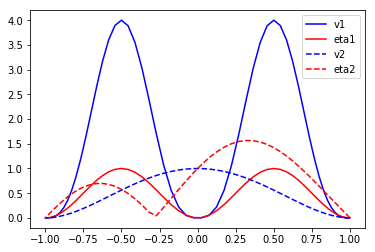

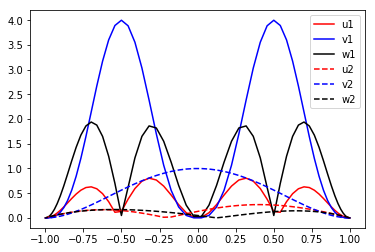

Divergences for the two fields are  2.51530736476e-14 5.93385466217e-15
Differences in v from veta and uvw are 0.0 0.0


In [17]:
# We need two state-vectors first
# They have to be divergence free, and satisfy the BCs
# It's easier to ensure divergence-free condition if I start with velocity vorticity
statInst = ops.statComp(a=2.5, b=20./3., N=62, Re=186.)
a = statInst.a; b = statInst.b; N = statInst.N
y = statInst.y
# Doesn't matter what the exact functions are, as long as BCs are good
# On eta, it's just eta(walls) = 0, but on v, it's both v=0 and v'=0
#eta1 = 1. - statInst.y**2 - (1. - statInst.y**4)**2
eta1 = (np.sin(np.pi*y))**2
eta2 = np.sin(np.pi*y) + (1. - y**2)**3
v1 =  -3.*np.sin(np.pi*y) + np.sin(3.*np.pi*y)
v2 = 2.*(1. - y**2) - (1. - y**4)

veta1 = np.concatenate((v1, eta1))
veta2 = np.concatenate((v2, eta2))
uvw1 = statInst.velVor2primitivesMat(a=a,b=b) @ veta1
#uvw1 = np.concatenate((1.-y**2, 0.*y, -1.+y**2))
uvw2 = statInst.velVor2primitivesMat(a=a,b=b) @ veta2

# Ensure that the divergence is actually zero
div1 = 1.j*a*uvw1[:N] + statInst.D1 @ uvw1[N:2*N] + 1.j*b*uvw1[2*N:3*N]
div2 = 1.j*a*uvw2[:N] + statInst.D1 @ uvw2[N:2*N] + 1.j*b*uvw2[2*N:3*N]

plt.plot(statInst.y, np.abs(veta1[0*N:1*N]), 'b')
plt.plot(statInst.y, np.abs(veta1[1*N:2*N]), 'r')
plt.plot(statInst.y, np.abs(veta2[0*N:1*N]), 'b--')
plt.plot(statInst.y, np.abs(veta2[1*N:2*N]), 'r--')
plt.legend(['v1','eta1', 'v2', 'eta2'])
plt.show()


plt.plot(statInst.y, np.abs(uvw1[0*N:1*N]), 'r')
plt.plot(statInst.y, np.abs(uvw1[1*N:2*N]), 'b')
plt.plot(statInst.y, np.abs(uvw1[2*N:3*N]), 'k')
plt.plot(statInst.y, np.abs(uvw2[0*N:1*N]), 'r--')
plt.plot(statInst.y, np.abs(uvw2[1*N:2*N]), 'b--')
plt.plot(statInst.y, np.abs(uvw2[2*N:3*N]), 'k--')
plt.legend(['u1','v1','w1', 'u2', 'v2', 'w2'])
plt.show()

print("Divergences for the two fields are ", pseudo.chebnorm(div1,N), pseudo.chebnorm(div2,N))
print("Differences in v from veta and uvw are", 
      pseudo.chebnorm(veta1[:N]-uvw1[N:2*N], N), pseudo.chebnorm(veta2[:N]-uvw2[N:2*N], N))



Both fields are valid; i.e., they are divergence-free. 

In [18]:
uvw1Weighted = statInst._weightVec(uvw1)
uvw2Weighted = statInst._weightVec(uvw2)

A,C,B = statInst.makeSystem()
Aadj, Cadj, Badj = statInst.makeAdjSystem()
AH = A.conj().T; BH = B.conj().T; CH = C.conj().T
state1 = B @ uvw1Weighted
state2 = B @ uvw2Weighted
assert state1.ndim==1 and state2.ndim==1

def _dot(vec1,vec2): 
    assert (vec1.ndim==1) and (vec2.ndim==1)
    return np.abs(np.sum( vec1 * vec2.conj() ))
tol = 1.0e-12
_approx = lambda scal1, scal2: np.abs(scal1-scal2) < tol

print("Are A, Aadj an adjoint pair (auto):", 
      _approx( _dot(A@state1, state1), _dot(state1, Aadj@state1) )  )
print("Are A, Aadj an adjoint pair (cross):", 
      _approx( _dot(A@state1, state2), _dot(state1, Aadj@state2) )  )
print("Are A, AH an adjoint pair (auto):", 
      _approx( _dot(A@state1, state1), _dot(state1, AH@state1) )  )
print("Are A, AH an adjoint pair (cross):", 
      _approx( _dot(A@state1, state2), _dot(state1, AH@state2) )  )



print("Are C, Cadj an adjoint pair (auto):", 
      _approx( _dot(C@state1, uvw1Weighted), _dot(state1, Cadj@uvw1Weighted) )  )
print("Are C, Cadj an adjoint pair (cross):", 
      _approx( _dot(C@state1, uvw2Weighted), _dot(state1, Cadj@uvw2Weighted) )  )
print("Are C, CH an adjoint pair (auto):", 
      _approx( _dot(C@state1, uvw1Weighted), _dot(state1, CH@uvw1Weighted) )  )
print("Are C, CH an adjoint pair (cross):", 
      _approx( _dot(C@state1, uvw2Weighted), _dot(state1, CH@uvw2Weighted) )  )



print("Are B, Badj an adjoint pair (auto):", 
      _approx( _dot(state1, B@uvw1Weighted), _dot(Badj@state1, uvw1Weighted) )  )
print("Are B, Badj an adjoint pair (cross):", 
      _approx( _dot(state1, B@uvw2Weighted), _dot(Badj@state1, uvw2Weighted) )  )
print("Are B, BH an adjoint pair (auto):", 
      _approx( _dot(state1, B@uvw1Weighted), _dot(BH@state1, uvw1Weighted) )  )
print("Are B, BH an adjoint pair (cross):", 
      _approx( _dot(state1, B@uvw2Weighted), _dot(BH@state1, uvw2Weighted) )  )







/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 2.5 6.666666666666667 186.0
a, b, Re: 2.5 6.666666666666667 186.0
Are A, Aadj an adjoint pair (auto): False
Are A, Aadj an adjoint pair (cross): False
Are A, AH an adjoint pair (auto): True
Are A, AH an adjoint pair (cross): True
Are C, Cadj an adjoint pair (auto): True
Are C, Cadj an adjoint pair (cross): True
Are C, CH an adjoint pair (auto): True
Are C, CH an adjoint pair (cross): True
Are B, Badj an adjoint pair (auto): True
Are B, Badj an adjoint pair (cross): True
Are B, BH an adjoint pair (auto): True
Are B, BH an adjoint pair (cross): True


Complex conjugates are the proper adjoint matrices under the Euclidean norm. The adjoint defined based on Jovanovic & Bamieh isn't accurate. It must be a typo in the paper. 

Nope. Not at all. The reason I don't see adjoincy is because I account for the transformation of the state-vector in defining A, but ignore that when defining the adjoint of A. 

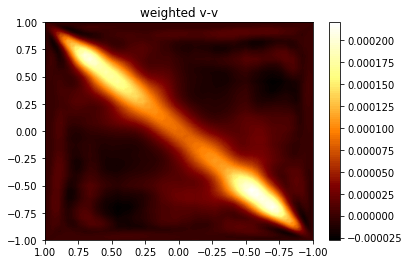

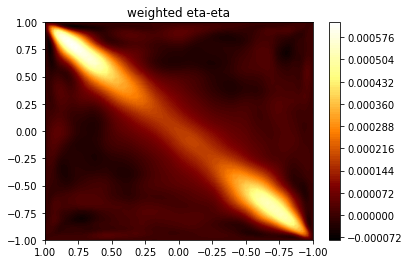

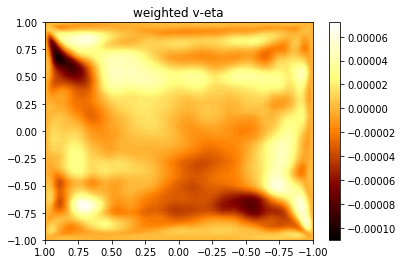

In [19]:
Phi = 4.*statInst.covMat/(0.25*2./3.)
X = B @ Phi @ B.conj().T
plt.contourf(y, y, np.real(X[:N,:N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("weighted v-v")
plt.show()

plt.contourf(y, y, np.real(X[N:,N:]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("weighted eta-eta")
plt.show()

plt.contourf(y, y, np.real(X[:N,N:]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("weighted v-eta")
plt.show()


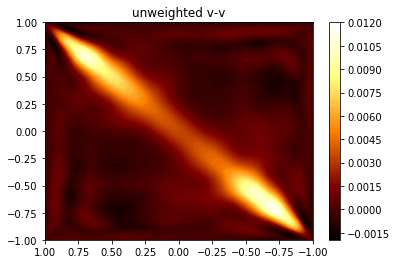

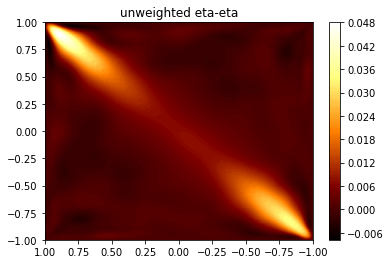

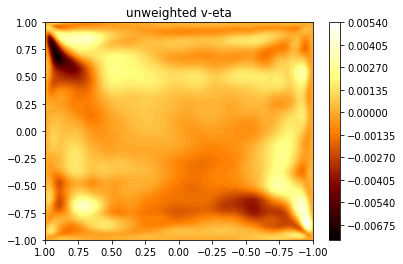

In [20]:
qInv = 1./np.sqrt(statInst.w)
Qinv = np.diag( np.concatenate((qInv,qInv)))
Xun = Qinv @ X @ Qinv
plt.contourf(y, y, np.real(Xun[:N,:N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted v-v")
plt.show()

plt.contourf(y, y, np.real(Xun[N:,N:]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted eta-eta")
plt.show()

plt.contourf(y, y, np.real(Xun[:N,N:]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted v-eta")
plt.show()


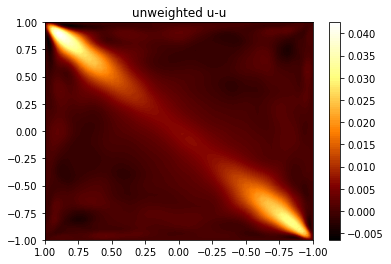

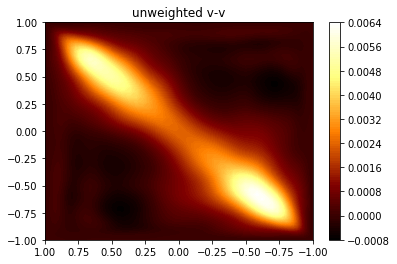

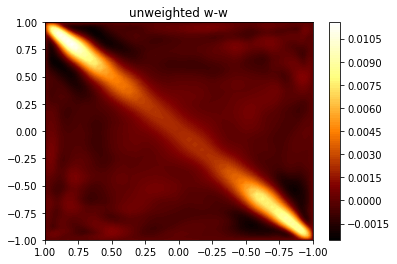

In [225]:

qInv = 1./np.sqrt(statInst.w)
Qinv = np.diag( np.concatenate((qInv,qInv,qInv)))
PhiUn = Qinv @ Phi @ Qinv
plt.contourf(y, y, np.real(PhiUn[:N,:N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted u-u")
plt.show()

plt.contourf(y, y, np.real(PhiUn[N:2*N,N:2*N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted v-v")
plt.show()

plt.contourf(y, y, np.real(PhiUn[2*N:3*N,2*N:3*N]),100,cmap=plt.get_cmap('afmhot'))
ax = plt.gca() 
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.colorbar()
plt.title("unweighted w-w")
plt.show()


# Testing $X = B \Phi B^*$ with test fields
The reason for doing this is, when I look at Phi[N:2N,N:2N] and X[:N,:N], which should both correspond to v-v covariance, they don't seem to match.

In [21]:
statInst = ops.statComp(a=2.5, b=20./3., N=62, Re=186.)
a = statInst.a; b = statInst.b; N = statInst.N
y = statInst.y
# Doesn't matter what the exact functions are, as long as BCs are good
# On eta, it's just eta(walls) = 0, but on v, it's both v=0 and v'=0
#eta1 = 1. - statInst.y**2 - (1. - statInst.y**4)**2
eta1 = (np.sin(np.pi*y))**2
eta2 = np.sin(np.pi*y) + (1. - y**2)**3
v1 =  -3.*np.sin(np.pi*y) + np.sin(3.*np.pi*y)
v2 = 2.*(1. - y**2) - (1. - y**4)

veta1 = np.concatenate((v1, eta1))
veta2 = np.concatenate((v2, eta2))
uvw1 = statInst.velVor2primitivesMat(a=a,b=b) @ veta1
#uvw1 = np.concatenate((1.-y**2, 0.*y, -1.+y**2))
uvw2 = statInst.velVor2primitivesMat(a=a,b=b) @ veta2

vel1 = statInst._weightVec(uvw1).reshape((uvw1.size,1))
vel2 = statInst._weightVec(uvw2).reshape((uvw2.size,1))

Phi1 = vel1 @ vel1.conj().T
Phi2 = vel2 @ vel2.conj().T

A,C,B = statInst.makeSystem()
state1 = B @ vel1.flatten()
state2 = B @ vel2.flatten()
X1 = B @ Phi1 @ B.conj().T
X2 = B @ Phi2 @ B.conj().T

vCovDiff1 = np.linalg.norm((Phi1[N:2*N, N:2*N] - X1[:N,:N]).flatten())**2
vCovDiff2 = np.linalg.norm((Phi2[N:2*N, N:2*N] - X2[:N,:N]).flatten())**2

vDiff1 = np.linalg.norm(vel1[N:2*N,0] - state1[:N])
vDiff2 = np.linalg.norm(vel2[N:2*N,0] - state2[:N])
#vDiff1 = np.linalg.norm(vel1[2*N:3*N,0] - state1[:N])
#vDiff2 = np.linalg.norm(vel2[2*N:3*N,0] - state2[:N])

print("vCovDiff1, vCovDiff2:", vCovDiff1, vCovDiff2)
print("vDiff1, vDiff2:", vDiff1, vDiff2)

Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666667 186.0
vCovDiff1, vCovDiff2: 4.41130273739 0.000839435949155
vDiff1, vDiff2: 0.497334122243 0.0256502439589


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


So, the first 'N' elements in the state are NOT the same as the N-2N elements in the (weighted) velocity vector!

In [22]:
Phi11 = C @ X1 @ C.conj().T
np.linalg.norm(Phi1 - Phi11, ord='fro')

2.9595057641185716e-14

In the end, I do recover $\Phi$ from $X$ using B and C

It's just that comparing the v-v sub-block in $\Phi$ to that in $X$ is wrong.

# Comparing my matrices with Zare's

Using parameters Re=186, alfa=46.5, kapa=0.61, N=127
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666667 186.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


Diff in weighted C: 0.63902640791
diff(C,Cm), diff(C1,Cm): 1.1315764015 0.940763107129
0.945586224301 0.793888663741 1.1315764015 3132609.5387 279634.702597


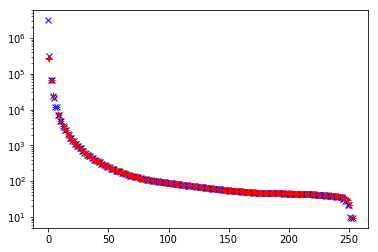

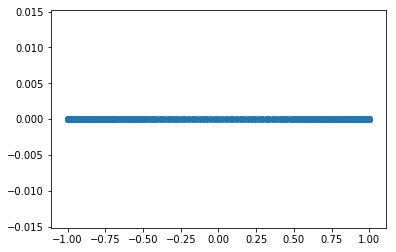

In [24]:
from scipy.io import loadmat
matDict = loadmat('data_figure9_jfm17.mat') # Data set from Zare
Am = matDict['A']; Cm = matDict['L']; Bm = Cm.conj().T
X = matDict['X']; ym = matDict['y'].flatten()
diffNorm = lambda mat1,mat2: np.linalg.norm(mat1-mat2, ord=2)/np.linalg.norm(mat1,ord=2)

a = 2.5; b = 20./3.; N = Am.shape[0]//2; Re = 186.
statInst = ops.statComp(a=a, b=b, N=N, Re=Re,
                        covMat=np.identity(3*N,dtype=np.complex))
A, C, B = statInst.makeSystem(weight=True)
q = np.sqrt(statInst.w); qi = 1./q
Q = np.diag(np.concatenate((q,q)))
Qi = np.diag(np.concatenate((qi,qi)))
Q3 = np.diag(np.concatenate((q,q,q)))
Qi3 = np.diag(np.concatenate((qi,qi,qi)))

C1 = Q3 @ C @ Qi
print("Diff in weighted C:", diffNorm(C1,C))
Adiff = diffNorm(A,Am)
Bdiff = diffNorm(B,Bm)
Cdiff = diffNorm(C,Cm)
print("diff(C,Cm), diff(C1,Cm):",diffNorm(C,Cm), diffNorm(C1,Cm))
U,S,V = np.linalg.svd(A); Um,Sm,Vm = np.linalg.svd(Am)
print(Adiff, Bdiff,Cdiff, np.linalg.norm(A,ord=2), np.linalg.norm(Am,ord=2))
#%matplotlib notebook
%matplotlib inline
plt.figure()
plt.plot(S,'bx')
plt.plot(Sm,'r+')
plt.yscale("log")
plt.show()



plt.scatter(ym,np.abs(statInst.y-ym))
plt.show()

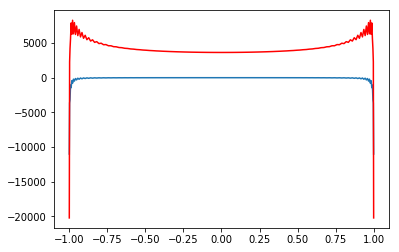

In [159]:
# Let's look at some of the diagonal elements on the dynamics matrix
N = ym.size; y =ym.flatten()
n = 2
plt.plot(y[n:N-n], np.diag(Am[:N,:N])[n:N-n].real)
plt.plot(y[n:N-n], np.diag(A[:N,:N])[n:N-n].real,'r')
#plt.yscale("log")
plt.show()

Okay, my dynamics matrix is a bit messed up. Zare's matrix is fairly smooth.

Where does this come from? 

Let's look at $A_\phi$ first before worrying about $A_\psi$.

a, b, Re: 2.5 6.666666666666667 186.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  dnu_ = np.diag( D1_ @ nu)


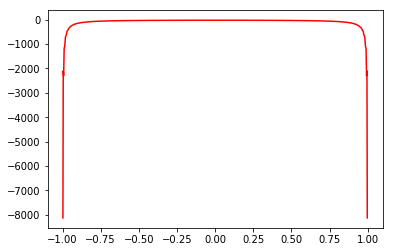

Using parameters Re=186, alfa=46.5, kapa=0.61, N=127


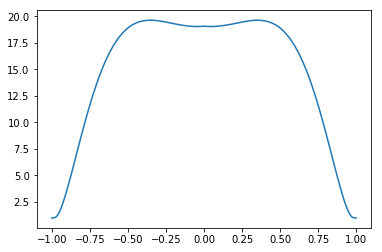

In [160]:
Aphi = statInst.dynamicsMat(a=statInst.a, b=statInst.b)
plt.plot(y[n:N-n], np.diag(Aphi[:N,:N])[n:N-n].real,'r')
#plt.yscale("log")
plt.show()

meanDict = ops.turbMeanChannel(N=N, Re=186.)
plt.plot(y, meanDict['nu'])

Nope, not good. Even $A_\phi$ is quite noisy. I wonder if that's because of the eddy viscosity bit.  

a, b, Re: 2.5 6.666666666666667 186.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  dnu_ = np.diag( D1_ @ nu)


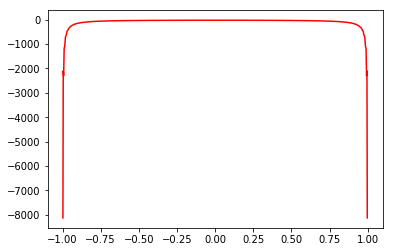

In [161]:
Aphi = statInst.dynamicsMat(a=statInst.a, b=statInst.b, nu=np.ones(N))
plt.plot(y[n:N-n], np.diag(Aphi[:N,:N])[n:N-n].real,'r')
#plt.yscale("log")
plt.show()


It's not the eddy viscosity. Is it the $\Delta^{-1}$ in the OSS operator?

# Diag of LOS for laminar base flow

Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=127
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


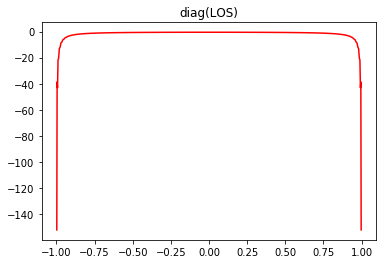

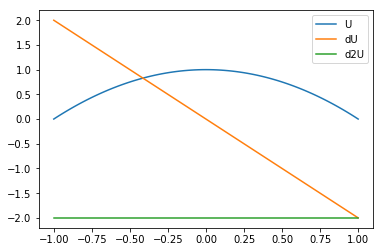

In [163]:
statInst = ops.statComp(a=1., b=1., N=127, Re=10000.,
                        covMat=np.identity(3*N,dtype=np.complex))

statInst.U = 1. - statInst.y**2
statInst.dU = -2.*statInst.y
statInst.d2U = -2.*np.ones(statInst.N)
U_ = np.diag(statInst.U)
dU_ = np.diag(statInst.dU)
d2U_ = np.diag(statInst.d2U)
D2_ = statInst.D2
D1_ = statInst.D1
D4_ = statInst.D4
I = np.identity(statInst.N)
Z = np.zeros(D1_.shape)
k2 = (statInst.a**2 + statInst.b**2)

nu_ = np.diag(np.ones(statInst.N))
dnu_ = np.diag(np.zeros(statInst.N))
d2nu_ = dnu_

a=1.; b=1.;k2 = 1.
#LOS  = 1.j*a* d2U_ - 1.j*a *( U_ @ ( D2_ - k2 *I ) )   \
#                +(1./Re) *(  nu_ @ (k2*k2*I - 2.*k2*D2_ + D4_ ))
LOS  = 1.j*a* d2U_ - 1.j*a *( U_ @ ( D2_ - k2 *I ) )   \
                +(1./Re) *(  nu_ @ (k2*k2*I - 2.*k2*D2_ + D4_ ) + 2.* dnu_ @ D1_ @ ( D2_ - k2 *I))

Re = statInst.Re; y = statInst.y
#LOS = (D4_ - 2.*D2_ + I)/Re - 2.j* I - 1.j* U_ @ (D2_ - I)
DeltaMat = D2_ - k2*I
DeltaInv = np.linalg.solve(DeltaMat, I)
LOS = DeltaInv @ LOS

plt.plot(y[n:N-n], np.diag(LOS[:N,:N])[n:N-n].real,'r')
#plt.yscale("log")
plt.title("diag(LOS)")
plt.show()


plt.plot(y, np.diag(U_))
plt.plot(y, np.diag(dU_))
plt.plot(y, np.diag(d2U_))
plt.legend(['U','dU', 'd2U'])
plt.show()


It works when I define nu, dnu, and d2nu explicitly. 

Now I know! D1 and D2 are defined to assume bvals to be zeroes. But nu isn't 0 at the walls, it's 1. 

I've changed the code to reflect this now. 

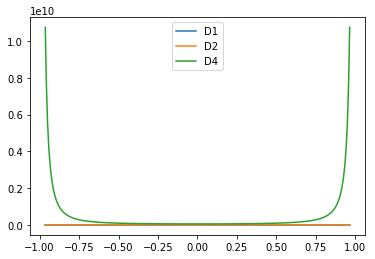

In [142]:
n = 10
plt.plot(y[n:N-n], np.diag(D1_[:N,:N])[n:N-n].real)
plt.plot(y[n:N-n], np.diag(D2_[:N,:N])[n:N-n].real)
plt.plot(y[n:N-n], np.diag(D4_[:N,:N])[n:N-n].real)
plt.legend(['D1','D2', 'D4'])
plt.show()


# Zare's covariance matrix (from CC)


In his email, he asked me to use L*X*L' to plot the covariance matrix of fig. 9 in his paper. If I take L here to be the same as 

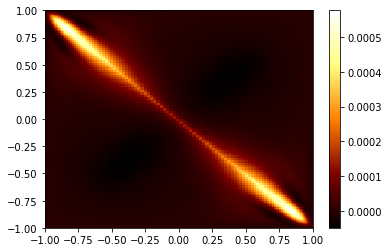

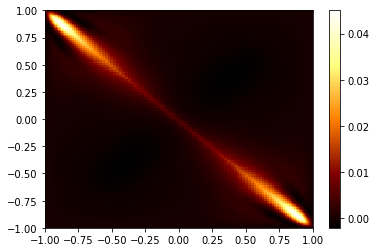

In [85]:
Phi = Cm @ X @ Cm.conj().T
qi = np.sqrt(1./statInst.w/2.)
Qi = np.diag(np.concatenate((qi,qi,qi)) )

Phi1 = Qi @ Phi @ Qi
plt.pcolor(ym, ym,  np.real(Phi[:N,:N][:,::-1]),cmap='afmhot')
plt.colorbar()
plt.show()

plt.pcolor(ym, ym,  np.real(Phi1[:N,:N][:,::-1]),cmap='afmhot')
plt.colorbar()
plt.show()

# Frequency response, from resolvent

In [25]:
from scipy.io import loadmat
a0 = 0.25; b0 = 2./3.; l = 10; m = 10; N = 62; Re = 186.
a = l*a0; b = m*b0
omegaArr = np.linspace(-100., 100.,201)
ampArrLNSE = np.zeros(omegaArr.size)
ampArrEddy =  np.zeros(omegaArr.size)
ampArrCC   =  np.zeros(omegaArr.size)
ampArrCC1  =  np.zeros(omegaArr.size)
psdArrLNSE = np.zeros(omegaArr.size)
psdArrEddy = np.zeros(omegaArr.size)
psdArrCC   = np.zeros(omegaArr.size)
psdArrCC1  = np.zeros(omegaArr.size)

statInst = ops.statComp(a=a, b=b, N=N, Re=Re)
A, C, B = statInst.makeSystem()
Ae, Ce, Be = statInst.makeSystem(nu=statInst.nu)

#==============================
# The modified dynamics system from covariance completion
matDict = loadmat('data_figure9_jfm17.mat') # Data set from Zare
Am = matDict['A']; Cm = matDict['L']; Bm = Cm.conj().T
Z = matDict['Z']; X = matDict['X']
Z = 0.5*(Z + Z.conj().T)
X = 0.5*(X + X.conj().T)    # Ensure X and Z are Hermitian
If = np.identity(Af.shape[0], dtype=np.complex)

Bm,Hm,Sm = ops.decomposeZ(Z)
HmAdj = Hm.conj().T
BmAdj = Bm.conj().T
CmAdj = Cm.conj().T
Xinv  = np.linalg.solve(X, If)

# Form modified dynamics system from covariance completed data
Cf = (HmAdj - 0.5*BmAdj)@ Xinv     # Eq. 3.6b 
Af = Am + Bm @ Cf                  # Eq. 3.6a
Bf = Bm
#==============================


#==============================
# Using matrices from my class, and complementing with X and Z from Zare
statInst1 = ops.statComp(a=a,b=b,N=Am.shape[0]//2, Re=Re,
                        covMat = np.identity(Cm.shape[0]))
A1, C1, B1 = statInst1.makeSystem()
A1*=4.
# Form modified dynamics system from covariance completed data
A1 = A1 + Bm @ Cf                  # Eq. 3.6a
B1 = Bm
#================================


N = A.shape[0]; I = np.identity(N,dtype=np.complex)
for ind in range(omegaArr.size):
    omega = omegaArr[ind]
    
    # LNSE 
    R = (1.j*omega*I + A )
    R = np.linalg.solve(R, I)
    Tvw = -C @ R @ B
    U,S,V = np.linalg.svd(Tvw)
    
    # LNSE with eddy
    RE = (1.j*omega*I + Ae )
    RE = np.linalg.solve(RE, I)
    Tvw_e = -C @ RE @ B
    U,Se,V = np.linalg.svd(Tvw_e)
    
    # Modified LNSE from CC
    RM = (1.j*omega*If + Af )
    RM = np.linalg.solve(RM, If)
    Tvw = -Cm @ RM @ Bm
    U,Sf,V = np.linalg.svd(Tvw)
    
    # Modified LNSE from CC, but using my dynamics matrix
    R1 = (1.j*omega*If + A1 )
    R1 = np.linalg.solve(R1, If)
    Tvw = -C1 @ R1 @ B1
    U,S1,V = np.linalg.svd(Tvw)

    ampArrLNSE[ind] = np.real(S[0])**2
    ampArrEddy[ind] = np.real(Se[0])**2
    ampArrCC[ind]   = np.real(Sf[0])**2
    ampArrCC1[ind]  = np.real(S1[0])**2
    
    psdArrLNSE[ind] = np.sum( np.real(S )**2 )
    psdArrEddy[ind] = np.sum( np.real(Se)**2 )
    psdArrCC[ind]   = np.sum( np.real(Sf)**2 )
    psdArrCC1[ind]  = np.sum( np.real(S1)**2 )
    



Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/cov/covR186N192l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666666 186.0
a, b, Re: 2.5 6.666666666666666 186.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


NameError: name 'Af' is not defined

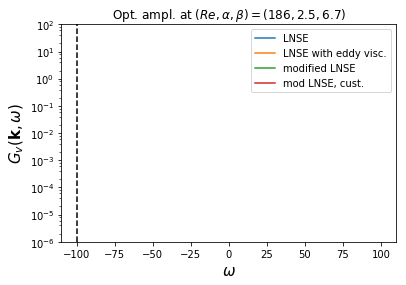

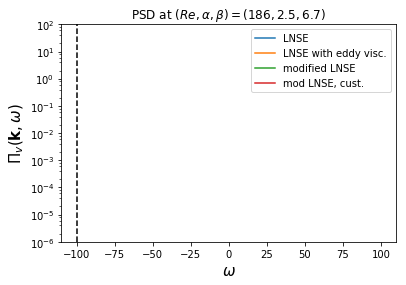

In [26]:
#figureFolder="figures/"
plt.plot(omegaArr, ampArrLNSE)
plt.plot(omegaArr, ampArrEddy)
plt.plot(omegaArr, ampArrCC  )
plt.plot(omegaArr, ampArrCC1 )
omegaInd = np.argmax(ampArrLNSE); omegaMax = omegaArr[omegaInd]
plt.plot(omegaMax*np.ones(15), 10**np.linspace(-6,2,15), 'k--')
plt.ylim([1.0e-06, 100.])
plt.yticks(10**np.array([-6.,-4.,-2.,0,2]))
plt.yscale("log")
plt.xlabel("$\\omega$", fontsize=15); plt.ylabel("$G_v(\mathbf{k},\\omega)$",fontsize=15)
plt.legend(['LNSE', 'LNSE with eddy visc.', 'modified LNSE','mod LNSE, cust.'])
plt.title("Opt. ampl. at $(Re,\\alpha,\\beta) =(186,2.5,6.7)$")
#plt.savefig(figureFolder+"optAmpLNSE.pdf",format="pdf")
plt.show()

plt.plot(omegaArr, psdArrLNSE)
plt.plot(omegaArr, psdArrEddy)
plt.plot(omegaArr, psdArrCC  )
plt.plot(omegaArr, psdArrCC1 )
omegaInd = np.argmax(psdArrLNSE); omegaMax = omegaArr[omegaInd]
plt.plot(omegaMax*np.ones(15), 10**np.linspace(-6,2,15), 'k--')
plt.ylim([1.0e-06, 100.])
plt.yticks(10**np.array([-6.,-4.,-2.,0.,2.]))
plt.yscale("log")
plt.xlabel("$\\omega$", fontsize=15); plt.ylabel("$\\Pi_v(\mathbf{k},\\omega)$",fontsize=15)
plt.legend(['LNSE', 'LNSE with eddy visc.', 'modified LNSE','mod LNSE, cust.'])
plt.title("PSD at $(Re,\\alpha,\\beta) =(186,2.5,6.7)$")
#plt.savefig(figureFolder+"psdLNSE.pdf",format="pdf")
plt.show()



When I plot the amplification for the modified system using my dynamics matrix, it's inaccurate. But the LNSE and LNSE+eddy are plotted here using my dynamics matrix. 

Actually, it's a bit funny now. I changed my ops.py file to set $\nu'_T$ and $\nu''_T$ to 0, along with a warning. This warning hasn't shown up here. So, I forgot to re-do the plots with the new version I suppose. 

Anyway, the next thing I'm going to do is see if I can reproduce the curve for the original LNSE using Zare's dynamics matrix. If something's off there, that means the matrices he gave me are defined differently than they should have been. 

In [31]:
from scipy.io import loadmat
a0 = 0.25; b0 = 2./3.; l = 10; m = 10; N = 62; Re = 186.
a = l*a0; b = m*b0
omegaArr = np.linspace(-100., 100.,201)
ampArrLNSE = np.zeros(omegaArr.size)
ampArrLNSEz = np.zeros(omegaArr.size)
ampArrCC   =  np.zeros(omegaArr.size)
psdArrLNSE = np.zeros(omegaArr.size)
psdArrLNSEz = np.zeros(omegaArr.size)
psdArrCC   = np.zeros(omegaArr.size)

#==============================
# The modified dynamics system from covariance completion
matDict = loadmat('data_figure9_jfm17.mat') # Data set from Zare
Am = matDict['A']; Cm = matDict['L']; Bm = Cm.conj().T
Z = matDict['Z']; X = matDict['X']
Z = 0.5*(Z + Z.conj().T)
X = 0.5*(X + X.conj().T)    # Ensure X and Z are Hermitian
If = np.identity(Am.shape[0], dtype=np.complex)

Bm,Hm,Sm = ops.decomposeZ(Z)
HmAdj = Hm.conj().T
BmAdj = Bm.conj().T
CmAdj = Cm.conj().T
Xinv  = np.linalg.solve(X, If)

# Form modified dynamics system from covariance completed data
Cf = (HmAdj - 0.5*BmAdj)@ Xinv     # Eq. 3.6b 
Af = Am + Bm @ Cf                  # Eq. 3.6a
Bf = Bm
#==============================


#==============================
# Original dynamics system, using Zare's dynamics matrix
Az = Am
Bz = CmAdj
Cz = Cm
#================================
Nm = Am.shape[0]//2; Im = np.identity(2*Nm,dtype=np.complex)

#===============================
# LNSE with my dynamics matrix
statInst = ops.statComp(a=a, b=b, N=Nm, Re=Re,
                       covMat=np.identity(3*Nm,dtype=np.complex))
A, C, B = statInst.makeSystem()
#==================================



for ind in range(omegaArr.size):
    omega = omegaArr[ind]
    
    # LNSE with my dynamics
    R = (1.j*omega*Im + A )
    R = np.linalg.solve(R, Im)
    Tvw = -C @ R @ B
    U,S,V = np.linalg.svd(Tvw)
    
    # LNSE with Zare's dynamics
    Rz = (1.j*omega*Im + Az )
    Rz = np.linalg.solve(Rz, Im)
    Tvw = -Cz @ Rz @ Bz
    U,Sz,V = np.linalg.svd(Tvw)
    
    # Modified LNSE from CC
    RM = (1.j*omega*If + Af )
    RM = np.linalg.solve(RM, If)
    Tvw = -Cm @ RM @ Bm
    U,Sf,V = np.linalg.svd(Tvw)
    
    ampArrLNSE[ind]  = np.real(S[0])**2
    ampArrLNSEz[ind] = np.real(Sz[0])**2
    ampArrCC[ind]    = np.real(Sf[0])**2
    
    psdArrLNSE[ind] = np.sum( np.real(S)**2 )
    psdArrLNSEz[ind] = np.sum( np.real(Sz)**2 )
    psdArrCC[ind]   = np.sum( np.real(Sf)**2 )
    



Using parameters Re=186, alfa=46.5, kapa=0.61, N=127
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666666 186.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


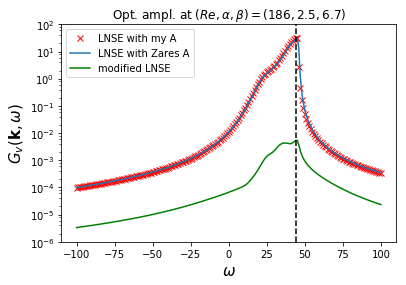

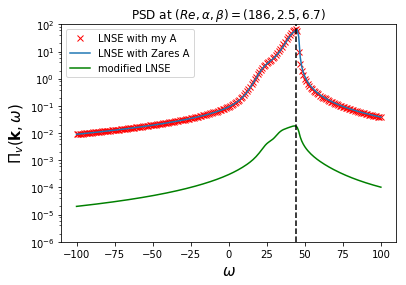

In [32]:
#figureFolder="figures/"
plt.plot(omegaArr, ampArrLNSE,'rx')
plt.plot(omegaArr, ampArrLNSEz)
plt.plot(omegaArr, ampArrCC  ,'g')
omegaInd = np.argmax(ampArrLNSE); omegaMax = omegaArr[omegaInd]
plt.plot(omegaMax*np.ones(15), 10**np.linspace(-6,2,15), 'k--')
plt.ylim([1.0e-06, 100.])
plt.yticks(10**np.array([-6.,-4.,-2.,0,2]))
plt.yscale("log")
plt.xlabel("$\\omega$", fontsize=15); plt.ylabel("$G_v(\mathbf{k},\\omega)$",fontsize=15)
plt.legend(['LNSE with my A', 'LNSE with Zares A', 'modified LNSE'])
plt.title("Opt. ampl. at $(Re,\\alpha,\\beta) =(186,2.5,6.7)$")
#plt.savefig(figureFolder+"optAmpLNSE.pdf",format="pdf")
plt.show()

plt.plot(omegaArr, psdArrLNSE, 'rx')
plt.plot(omegaArr, psdArrLNSEz)
plt.plot(omegaArr, psdArrCC  ,'g')
omegaInd = np.argmax(psdArrLNSE); omegaMax = omegaArr[omegaInd]
plt.plot(omegaMax*np.ones(15), 10**np.linspace(-6,2,15), 'k--')
plt.ylim([1.0e-06, 100.])
plt.yticks(10**np.array([-6.,-4.,-2.,0.,2.]))
plt.yscale("log")
plt.xlabel("$\\omega$", fontsize=15); plt.ylabel("$\\Pi_v(\mathbf{k},\\omega)$",fontsize=15)
plt.legend(['LNSE with my A', 'LNSE with Zares A', 'modified LNSE'])
plt.title("PSD at $(Re,\\alpha,\\beta) =(186,2.5,6.7)$")
#plt.savefig(figureFolder+"psdLNSE.pdf",format="pdf")
plt.show()



Interesting. So the amplification from my dynamics matrix matches that of Zare's. Of course, the amplification above also factors in the input and output matrices.

Just to make sure I didn't mess things up earlier, let's look at SVD of just the dynamics matrices without regard to the other matrices. 

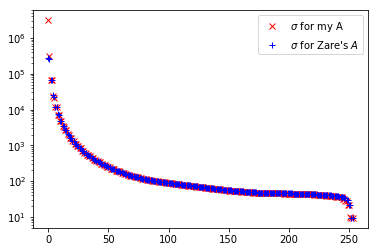

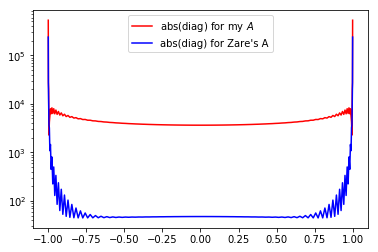

In [71]:
U,S,V = np.linalg.svd(A)
U,Sz,V = np.linalg.svd(Az)
plt.plot(S,'rx')
plt.plot(Sz,'b+')
plt.yscale("log")
plt.legend(["$\\sigma$ for my A", "$\\sigma$ for Zare's $A$"])
plt.savefig(figureFolder+'compareSVD.eps', format='eps')
plt.show()

y = pseudo.chebdif(Nm,1)[0]
plt.figure()
plt.plot(y, np.abs(np.diag(A[:Nm,:Nm])),'r')
plt.plot(y, np.abs(np.diag(Az[:Nm,:Nm])),'b')
plt.yscale("log")
plt.legend(["abs(diag) for my $A$", "abs(diag) for Zare's A"])
plt.savefig(figureFolder+'compareDiag.eps', format='eps')
plt.show()


Good, so it wasn't a mistake earlier. The dynamics matrices are clearly different. But the compounded action of the transfer function, $-C(i\omega I +A)^{-1}B$, is identical. 



# Figuring out the difference in definitions
Now I'm a lot more sure that the difference is in definitions. Probably the weighting somewhere is off. 

In [77]:
from scipy.io import loadmat

a0 = 0.25; b0 = 2./3.; l = 10; m = 10; N = 127; Re = 186.
Nm = N
a = l*a0; b = m*b0
def compareMats(A,B,C,Az,Bz,Cz,printFigs=False):
    omegaArr = np.linspace(15., 75.,61)
    ampArrLNSE = np.zeros(omegaArr.size)
    ampArrLNSEz = np.zeros(omegaArr.size)
    psdArrLNSE = np.zeros(omegaArr.size)
    psdArrLNSEz = np.zeros(omegaArr.size)

    Im = np.identity(2*Nm,dtype=np.complex)

    
    for ind in range(omegaArr.size):
        omega = omegaArr[ind]

        # LNSE with my dynamics
        R = (1.j*omega*Im + A )
        R = np.linalg.solve(R, Im)
        Tvw = -C @ R @ B
        U,S,V = np.linalg.svd(Tvw)

        # LNSE with Zare's dynamics
        Rz = (1.j*omega*Im + Az )
        Rz = np.linalg.solve(Rz, Im)
        Tvw = -Cz @ Rz @ Bz
        U,Sz,V = np.linalg.svd(Tvw)

        ampArrLNSE[ind]  = np.real(S[0])**2
        ampArrLNSEz[ind] = np.real(Sz[0])**2

        psdArrLNSE[ind] = np.sum( np.real(S)**2 )
        psdArrLNSEz[ind] = np.sum( np.real(Sz)**2 )


    plt.plot(omegaArr, ampArrLNSE,'rx')
    plt.plot(omegaArr, ampArrLNSEz)
    omegaInd = np.argmax(ampArrLNSE); omegaMax = omegaArr[omegaInd]
    plt.plot(omegaMax*np.ones(15), 10**np.linspace(-6,2,15), 'k--')
    plt.ylim([1.0e-06, 100.])
    plt.yticks(10**np.array([-6.,-4.,-2.,0,2]))
    plt.yscale("log")
    plt.xlabel("$\\omega$", fontsize=15); plt.ylabel("$G_v(\mathbf{k},\\omega)$",fontsize=15)
    plt.legend(["LNSE with my A", "LNSE with Zare's A"])
    plt.title("Opt. ampl. at $(Re,\\alpha,\\beta) =(186,2.5,6.7)$")
    if printFigs:
        plt.savefig(figureFolder+"optAmpLNSE.eps",format="eps")
    plt.show()

    plt.plot(omegaArr, psdArrLNSE, 'rx')
    plt.plot(omegaArr, psdArrLNSEz)
    omegaInd = np.argmax(psdArrLNSE); omegaMax = omegaArr[omegaInd]
    plt.plot(omegaMax*np.ones(15), 10**np.linspace(-6,2,15), 'k--')
    plt.ylim([1.0e-06, 100.])
    plt.yticks(10**np.array([-6.,-4.,-2.,0.,2.]))
    plt.yscale("log")
    plt.xlabel("$\\omega$", fontsize=15); plt.ylabel("$\\Pi_v(\mathbf{k},\\omega)$",fontsize=15)
    plt.legend(['LNSE with my A', "LNSE with Zare's A"])
    plt.title("PSD at $(Re,\\alpha,\\beta) =(186,2.5,6.7)$")
    if printFigs:
        plt.savefig(figureFolder+"psdLNSE.eps",format="eps")
    plt.show()
    
    
    U,S,V = np.linalg.svd(A)
    U,Sz,V = np.linalg.svd(Az)
    plt.plot(S,'rx')
    plt.plot(Sz,'b+')
    plt.yscale("log")
    plt.legend(['$\\sigma$ for my A', "$\\sigma$ for Zare's A"])
    plt.ylabel("$\\sigma$",fontsize=15)
    if printFigs:
        plt.savefig(figureFolder+"compareSVDA.eps",format="eps")
    plt.show()

    y = pseudo.chebdif(Nm,1)[0]
    plt.figure()
    plt.plot(np.arange(Nm), np.abs(np.diag(A[:Nm,:Nm])),'r')
    plt.plot(np.arange(Nm), np.abs(np.diag(Az[:Nm,:Nm])),'b')
    plt.yscale("log")
    plt.ylabel("abs(diag($A_{11}$))",fontsize=15)
    plt.legend(['abs(diag) for my A', "abs(diag) for Zare's A"])
    if printFigs:
        plt.savefig(figureFolder+"compareAbsDiagA.eps",format="eps")
    plt.show()
    
    y = pseudo.chebdif(Nm,1)[0][5:-5]
    plt.figure()
    plt.plot(np.arange(5,Nm-5), np.real(np.diag(A[5:Nm-5,5:Nm-5])),'r')
    plt.plot(np.arange(5,Nm-5), np.real(np.diag(Az[5:Nm-5,5:Nm-5])),'b')
    #plt.yscale("log")
    plt.ylabel("real(diag($A_{11}$))",fontsize=15)
    plt.legend(['real(diag) for my A', "real(diag) for Zare's A"])
    if printFigs:
        plt.savefig(figureFolder+"compareRealDiagA.eps",format="eps")
    plt.show()
    
    y = pseudo.chebdif(Nm,1)[0][5:-5]
    plt.figure()
    plt.plot(np.arange(5,Nm-5), np.imag(np.diag(A[5:Nm-5,5:Nm-5])),'r')
    plt.plot(np.arange(5,Nm-5), np.imag(np.diag(Az[5:Nm-5,5:Nm-5])),'b')
    #plt.yscale("log")
    plt.legend(['imag(diag) for my A', "imag(diag) for Zare's A"])
    plt.ylabel("imag(diag($A_{11}$))",fontsize=15)
    if printFigs:
        plt.savefig(figureFolder+"compareImagDiagA.eps",format="eps")
    plt.show()
    
    
    U,S,V = np.linalg.svd(C)
    U,Sz,V = np.linalg.svd(Cz)
    plt.plot(S,'rx')
    plt.plot(Sz,'b+')
    plt.yscale("log")
    plt.ylabel("$\\sigma$",fontsize=15)
    plt.legend(['$\\sigma$ for my C', "$\\sigma$ for Zare's C"])
    if printFigs:
        plt.savefig(figureFolder+"compareSVDC.eps",format="eps")
    plt.show()

    y = pseudo.chebdif(Nm,1)[0]
    plt.figure()
    plt.plot(np.arange(Nm), np.abs(np.diag(C[:Nm,:Nm])),'r')
    plt.plot(np.arange(Nm), np.abs(np.diag(Cz[:Nm,:Nm])),'b')
    plt.yscale("log")
    plt.legend(["abs(diag) for my $C$", "abs(diag) for Zare's $C$"])
    plt.ylabel("abs(diag($C_{11}$))",fontsize=15)
    if printFigs:
        plt.savefig(figureFolder+"compareAbsDiagC.eps",format="eps")
    plt.show()
    
    return


Right, now we have a nice function all ready to compare the matrices from the different systems. 


What we have is, to within singular values, 
$$CA^{-1]B$$
is identical from my definitions and Zare's (I can ignore the $i\omega I$ factors if I consider the resolvent at $\omega =0$ ). 


Using parameters Re=186, alfa=46.5, kapa=0.61, N=127
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666666 186.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


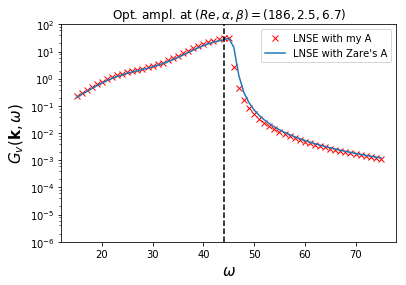

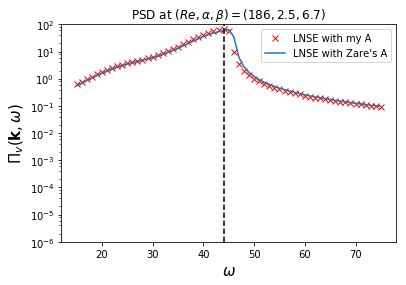

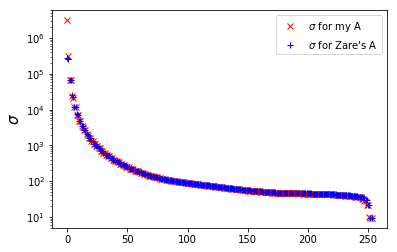

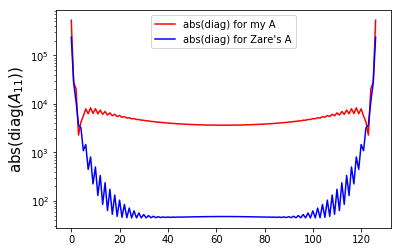

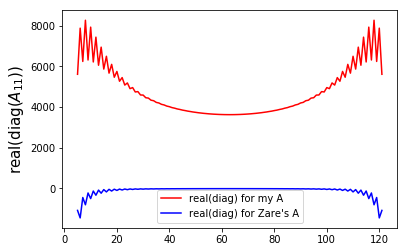

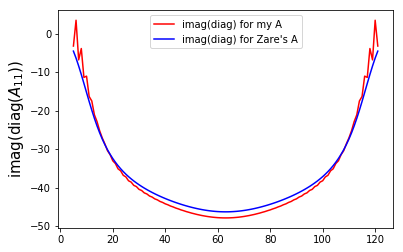

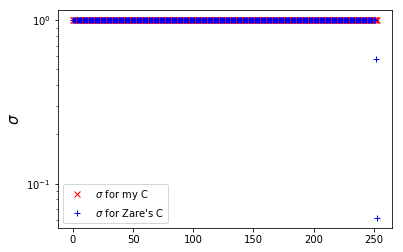

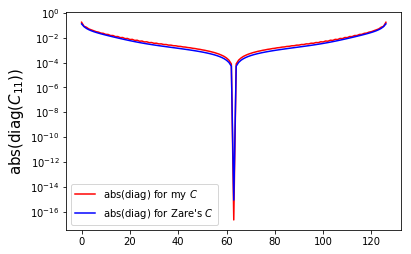

In [78]:
matDict = loadmat('data_figure9_jfm17.mat') # Data set from Zare
Az = matDict['A']; Cz = matDict['L']; Bz = Cz.conj().T

statInst = ops.statComp(a=a, b=b, N=Nm, Re=Re,
                       covMat=np.identity(3*Nm,dtype=np.complex))
A, C, B = statInst.makeSystem()






compareMats(A,B,C, Az, Bz, Cz,printFigs=True)

In [66]:
n = C.shape[0]; nh = n//2
Ihalf = np.identity(n); Ihalf[nh:,nh:] = 0.
print(np.linalg.norm(  (C.conj().T @ C)- np.identity(C.shape[1]),ord='nuc'  ),
np.linalg.norm(  (Cz.conj().T @ Cz)- np.identity(Cz.shape[1]),ord='nuc'  )  , np.linalg.norm((Cz.conj().T @ Cz ), ord='nuc')  )

3.61629289531e-12 1.66530440934 252.334695591


So, Zare's C is not only different from mine, it's also ''non-unitary''. 

That just doesn't seem right. 

He asked me to define the constraint equation as
$$ E.* (LXL') = G$$
I wonder if $G$ is weighted or not. 

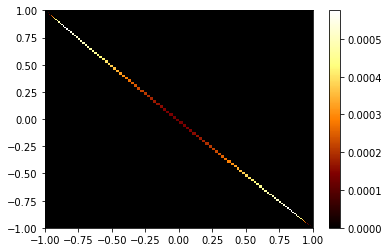

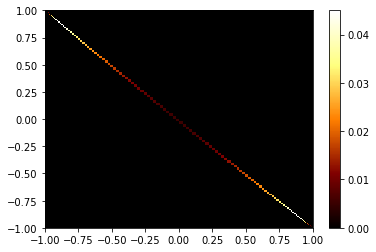

In [70]:
Phi = matDict['G']
ym = y
qi = np.sqrt(1./statInst.w/2.)
Qi = np.diag(np.concatenate((qi,qi,qi)) )

Phi1 = Qi @ Phi @ Qi
plt.pcolor(ym, ym,  np.real(Phi[:N,:N][:,::-1]),cmap='afmhot')
plt.colorbar()
plt.show()

plt.pcolor(ym, ym,  np.real(Phi1[:N,:N][:,::-1]),cmap='afmhot')
plt.colorbar()
plt.show()

So $G$ is weighted in his code, as it should be. 
Then, the $L$ that he uses should be the same as my $C$. Which should be unitary. I don't see why it's not. 

(381, 223)


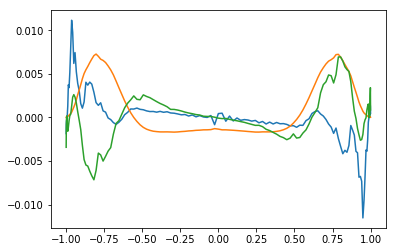

In [45]:
inModes = Cm @ Bm[:,:]    # First column of B, in velocity field space
nm = inModes.shape[1]
Nm = 127
print(inModes.shape)
inModes = inModes.T.reshape((nm,3,Nm))
# Dump the last cheb mode in each inMode
inModes = pseudo.chebFilter(inModes,Ndrop=10)


y = pseudo.chebdif(Nm,1)[0]
plt.plot(y, np.real(inModes[0,0]))
plt.plot(y, np.real(inModes[0,1]))
plt.plot(y, np.real(inModes[0,2]))
plt.show()

In [17]:
np.linalg.matrix_rank(Bm)

223

In [23]:
arr1 = np.arange(24).reshape((4,6))
arr2 = arr1.reshape((4,2,3))
print(arr1)
print(arr2)

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]]
[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]]

 [[18 19 20]
  [21 22 23]]]


# Sqrt(Q) in $A_\psi = Q^{1/2} A_\phi Q^{-1/2}$

In [80]:
statInst = ops.statComp(a=2.5, b=20./3., N=62,Re=186.,
                   covMat = np.identity(186))
Aphi = statInst.dynamicsMat(a=statInst.a, b=statInst.b)
Cphi = statInst.velVor2primitivesMat(a=statInst.a, b=statInst.b)
w = statInst.w
W = np.diag(np.concatenate((w,w,w)))

Using parameters Re=186, alfa=46.5, kapa=0.61, N=62
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666667 186.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


In [84]:
from scipy.linalg import sqrtm
Q = Cphi.conj().T @ W @ Cphi
Qsqrt = sqrtm(Q)
QsqrtInv = np.linalg.solve(Qsqrt, np.identity(Qsqrt.shape[0]))

np.linalg.norm(QsqrtInv@Qsqrt - np.identity(Qsqrt.shape[0]))

5.6193495984030735e-15

# Forcing response
After a preliminary run of the CCAMA algo in MATLAB, I found that the iterations based on my dynamics matrix starts with improper values for covariance at the walls. This can be seen in the movies I made (folder $LINLIB/ccamaClean on the laptop). 

The initial covariance matrix has nothing to do with the CC problem, and comes directly from solving the Lyapunov equation for the turbulent mean based OSS matrix. 

Using parameters Re=186, alfa=46.5, kapa=0.61, N=127
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666667 186.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


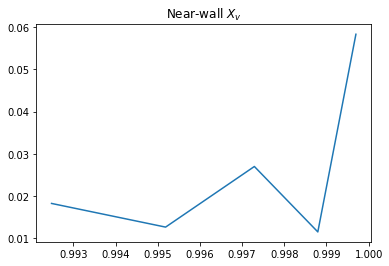

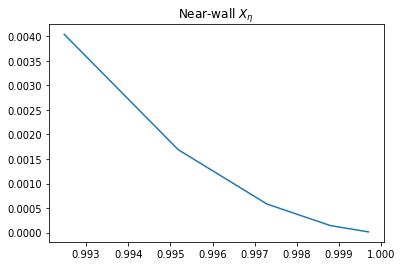

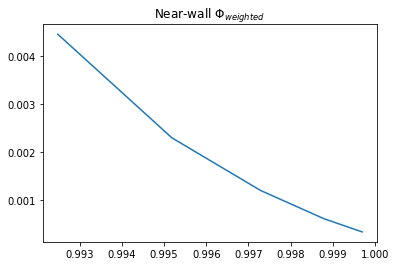

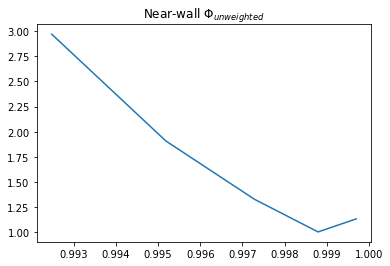

In [17]:
N = 127; Re = 186.; a = 2.5; b = 20./3.
I2 = np.identity(2*N); I3 = np.identity(3*N)
statInst = ops.statComp(N=127, Re=186., a=2.5, b=20./3., covMat = I3)
A,C,B = statInst.makeSystem()
y = statInst.y

X = solve_lyapunov(A, -I2)
# Covariance on transformed vel-vor

weightDict = pseudo.weightMats(statInst.N)
# Dictionary with different weight matrices
W3SqrtInv = weightDict['W3SqrtInv']

Phi = C @ X @ C.conj().T
# Covariance on weighted velocity comps

PhiUn = W3SqrtInv @ Phi @ W3SqrtInv
# Covariance on unweighted velocity comps

plt.plot(y[:5], np.diag(X[:5,:5]).real )
plt.title("Near-wall $X_v$")
plt.show()

plt.plot(y[:5], np.diag(X[N:N+5,N:N+5]).real )
plt.title("Near-wall $X_\\eta$")
plt.show()

plt.plot(y[:5], np.diag(Phi[:5,:5]).real )
plt.title("Near-wall $\\Phi_{weighted}$")
plt.show()

plt.plot(y[:5], np.diag(PhiUn[:5,:5]).real )
plt.title("Near-wall $\\Phi_{unweighted}$")
plt.show()



I'm not sure where the problem is. Instead of randomly looking for a bug, I'll try and reproduce the results of 

## Farrell & Ioannou 1993, PoF: Stochastic forcing of the linearized NSE

They give out the formulation in good detail, along with a derivation for the Lyapunov equation. What I'm looking for is

1) A comparison of the dynamics matrix from my statComp.makeSystem() and a dynamics matrix defined according to the paper, and 
2) Matching the results of the paper.

In [18]:
from scipy.linalg import sqrtm

In [23]:
N = 127; Re = 186.; a = 2.5; b = 20./3.

I1 = np.identity(N,dtype=np.complex); Z1 = np.zeros((N,N), dtype=np.complex)
I2 = np.identity(2*N,dtype=np.complex); I3 = np.identity(3*N,dtype=np.complex)

statInst = ops.statComp(N=127, Re=186., a=2.5, b=20./3., covMat = I3)
statInst.U = 1. - statInst.y**2
statInst.dU = -2.*statInst.y
statInst.d2U = -2.*np.ones(statInst.y.shape)
A,C,B = statInst.makeSystem()
y = statInst.y

Aphi = statInst.OSS(a =a, b=b)
Cphi = statInst.velVor2primitivesMat(a=a,b=b)
Delta = statInst.D2 - (a**2 + b**2) * I1

M = np.vstack(( np.hstack((-Delta, Z1)), np.hstack((Z1, I1)) ))
Msqrt = sqrtm(M)
assert np.linalg.norm(Msqrt@Msqrt -M, 'fro')/np.linalg.norm(M,'fro') <= 1.0e-09
MsqrtInv = np.linalg.solve(Msqrt, I2)
assert np.linalg.norm(Msqrt@MsqrtInv -I2, 'fro')/np.linalg.norm(I2,'fro') <= 1.0e-09

# Action of M is to give u^2 + v^2 + w^2 from u,v,w
Apsi = Msqrt @ Aphi @ MsqrtInv
# We also need weight matrices to account for Chebyshev nodes
weightDict = pseudo.weightMats(N)
W2Sqrt = weightDict['W2Sqrt']; W2SqrtInv = weightDict['W2SqrtInv']
Apsi = W2Sqrt @ Apsi @ W2SqrtInv

# Compare Apsi from the paper with mine
print("Relative norm of difference in dynamics matrices is")
print(np.linalg.norm(A-Apsi)/np.linalg.norm(A))

Using parameters Re=186, alfa=46.5, kapa=0.61, N=127
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666667 186.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 2.5 6.666666666666667 186.0
Relative norm of difference in dynamics matrices is
0.974903163796


This didn't prove very useful. In the paper, they don't talk about weighting the fields to allow for quadrature. So I'll go directly to the results (Fig. 2)

In [16]:
aArr = 10**np.arange(-1., 1.51, 0.25)
bArr = 10**np.arange(-1., 1.01, 0.25)
Earr = np.zeros((aArr.size,bArr.size))
N = 127; Re = 2000.
I1 = np.identity(N,dtype=np.complex); Z1 = np.zeros((N,N), dtype=np.complex)
I2 = np.identity(2*N,dtype=np.complex); I3 = np.identity(3*N,dtype=np.complex)
statInst = ops.statComp(N=N, Re=Re, a=aArr[0], b=bArr[0], covMat = I3)
y = statInst.y
statInst.U = 1. - statInst.y**2
statInst.dU = -2.*statInst.y
statInst.d2U = -2.*np.ones(statInst.y.shape)

weightDict = pseudo.weightMats(N)
W2Sqrt = weightDict['W2Sqrt']; W2SqrtInv = weightDict['W2SqrtInv']
Delta = statInst.D2 - (a**2 + b**2) * I1

M = np.vstack(( np.hstack((-Delta, Z1)), np.hstack((Z1, I1)) ))
Msqrt = sqrtm(M)
assert np.linalg.norm(Msqrt@Msqrt -M, 'fro')/np.linalg.norm(M,'fro') <= 1.0e-09
MsqrtInv = np.linalg.solve(Msqrt, I2)
assert np.linalg.norm(Msqrt@MsqrtInv -I2, 'fro')/np.linalg.norm(I2,'fro') <= 1.0e-09

# Apsi = Msqrt @ Aphi @ MsqrtInv
# We also need weight matrices to account for Chebyshev nodes
# weightDict = pseudo.weightMats(N)
# W2Sqrt = weightDict['W2Sqrt']; W2SqrtInv = weightDict['W2SqrtInv']
# Apsi = W2Sqrt @ Apsi @ W2SqrtInv


for i0 in range(aArr.size):
    a = aArr[i0]
    for i1 in range(bArr.size):
        b = bArr[i1]
        statInst.a = a
        statInst.b = b

        
        A,C,B = statInst.makeSystem()
        #A = statInst.dynamicsMat(a=a, b=b)
        #A = Msqrt @ A @ MsqrtInv
        
        X = solve_sylvester(A, A.conj().T, -I2)
        Earr[i0,i1] = np.trace(X)

        

Using parameters Re=2000, alfa=25.4, kapa=0.426, N=127
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 0.1 0.1 2000.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")
/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


a, b, Re: 0.1 0.177827941004 2000.0
a, b, Re: 0.1 0.316227766017 2000.0
a, b, Re: 0.1 0.56234132519 2000.0
a, b, Re: 0.1 1.0 2000.0
a, b, Re: 0.1 1.77827941004 2000.0
a, b, Re: 0.1 3.16227766017 2000.0
a, b, Re: 0.1 5.6234132519 2000.0
a, b, Re: 0.1 10.0 2000.0
a, b, Re: 0.177827941004 0.1 2000.0
a, b, Re: 0.177827941004 0.177827941004 2000.0
a, b, Re: 0.177827941004 0.316227766017 2000.0
a, b, Re: 0.177827941004 0.56234132519 2000.0
a, b, Re: 0.177827941004 1.0 2000.0
a, b, Re: 0.177827941004 1.77827941004 2000.0
a, b, Re: 0.177827941004 3.16227766017 2000.0
a, b, Re: 0.177827941004 5.6234132519 2000.0
a, b, Re: 0.177827941004 10.0 2000.0
a, b, Re: 0.316227766017 0.1 2000.0
a, b, Re: 0.316227766017 0.177827941004 2000.0
a, b, Re: 0.316227766017 0.316227766017 2000.0
a, b, Re: 0.316227766017 0.56234132519 2000.0
a, b, Re: 0.316227766017 1.0 2000.0
a, b, Re: 0.316227766017 1.77827941004 2000.0
a, b, Re: 0.316227766017 3.16227766017 2000.0
a, b, Re: 0.316227766017 5.6234132519 2000.0
a, 

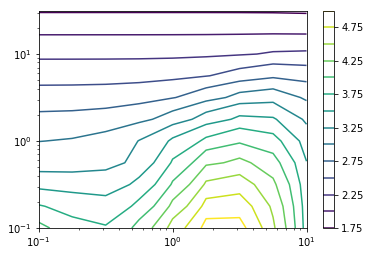

In [17]:
plt.contour(bArr, aArr, np.log10(Earr), 15)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

plt.show()

## Eddy viscosity 
First, let's see if the eddy viscosity is properly accounted for. 


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 17.978885957543874 125.85220170280711 2003.0
Without eddy viscosity.....


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:231: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


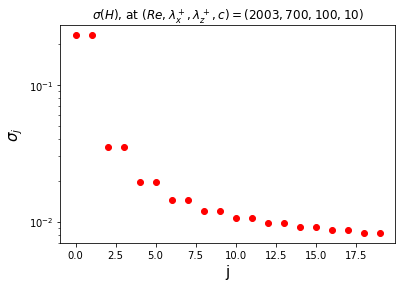

Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
a, b, Re: 17.978885957543874 125.85220170280711 2003.0
With eddy viscosity.....


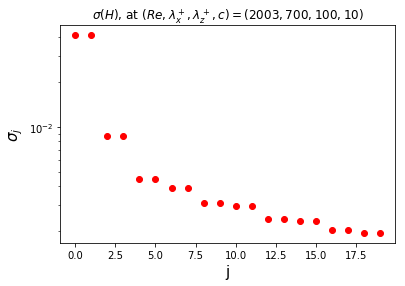

Eddy viscosity plot...


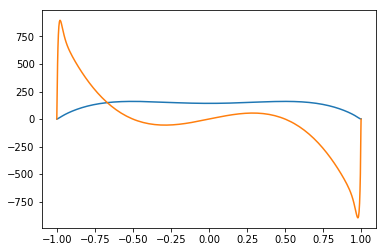

Diff in dynamics mats: 36935.5258722


In [29]:
Re = 2003.; alfa = 25.4; kapa = 0.426; N = 150

# Fig 4.a in paper is for lx+ = 700, lz+ = 100, c = 10
# a = 2*pi/lx = 2*pi/(lx+ /ReTau) = ReTau * 2*pi/lx+
a = 2.*np.pi*Re/700.
b = 2.*np.pi*Re/100.
c = 10.; omega = a*c


statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))

statInst.nu = np.ones(N)
A = statInst.OSS(a=a,b=b)
A0= A.copy()
C = statInst.velVor2primitivesMat(a=a,b=b)
Cadj = statInst.primitives2velVorMat(a=a,b=b)
R = ( 1.j*omega*np.identity(2*N) + A )
R = - np.linalg.solve(R,np.identity(R.shape[0]))
H = C @ R @ Cadj
H = statInst._weightMat(H)

print("Without eddy viscosity.....")
U,S,V = np.linalg.svd(H)
plt.plot(np.arange(20),S[:20],'ro')
plt.yscale("log")
plt.xlabel("j",fontsize=15); plt.ylabel("$\\sigma_j$",fontsize=15)
plt.title("$\\sigma(H)$, at $(Re,\\lambda^+_x,\\lambda^+_z,c)=(2003,700,100,10)$")
#plt.savefig(figureFolder+'svalsRe2003lx700lz100.pdf',format='pdf')
plt.show()

statInst1 = copy.deepcopy(statInst)
statInst1.nu = ops.turbMeanChannel(N=N,Re=Re)['nu']
A = statInst1.dynamicsMat()
C = statInst.outputMat()
Cadj = statInst.primitives2velVorMat(a=a,b=b)
R = ( 1.j*omega*np.identity(2*N) + A )
R = - np.linalg.solve(R,np.identity(R.shape[0]))
H = C @ R @ Cadj
H = statInst._weightMat(H)

print("With eddy viscosity.....")
U,S,V = np.linalg.svd(H)
plt.plot(np.arange(20),S[:20],'ro')
plt.yscale("log")
plt.xlabel("j",fontsize=15); plt.ylabel("$\\sigma_j$",fontsize=15)
plt.title("$\\sigma(H)$, at $(Re,\\lambda^+_x,\\lambda^+_z,c)=(2003,700,100,10)$")
#plt.savefig(figureFolder+'svalsRe2003lx700lz100.pdf',format='pdf')
plt.show()

print("Eddy viscosity plot...")
plt.plot(statInst.y, statInst1.nu)
plt.plot(statInst.y, statInst1.D1 @ ( statInst1.nu - statInst1.nu[0]))
plt.show()

print("Diff in dynamics mats:", np.linalg.norm(A-A0))

Using parameters Re=2003, alfa=25.4, kapa=0.426, N=150
a, b, Re: 17.978885957543874 125.85220170280711 2003.0
a, b, Re: 17.978885957543874 125.85220170280711 2003.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:231: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


(36935.525872232291, 9066.7076410138088)

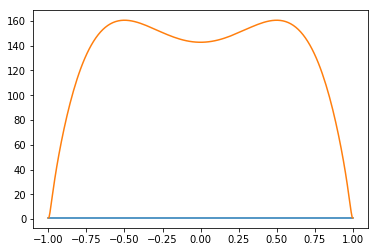

In [24]:
import copy
statInst0 = copy.deepcopy(statInst)
statInst0.nu = np.ones(statInst.N)
statInst.nu = ops.turbMeanChannel(N=statInst.N,Re=statInst.Re)['nu']
plt.plot(statInst.y, statInst0.nu)
plt.plot(statInst.y, statInst.nu)

A0 = statInst0.dynamicsMat()
A  = statInst.dynamicsMat()
np.linalg.norm(A-A0,ord='fro'), np.linalg.norm(A-A0,ord=2)